### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Градиентный бустинг


**Общая информация**

**Срок сдачи:** 10 мая 2021, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 10 мая, -4 балла после 08:30 17 мая, -6 баллов после 08:30 24 мая, -8 баллов после 08:30 31 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0221, Задание 4] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте. 

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге. 

1)$\frac{\partial L(a(x_{i}),y_{i})}{\partial a(x_{i})}\ =\ -2(y_{i} - a(x_{i}))$

$Таргет: 2(y_{i} - a(x_{i}))$

2)$\frac{\partial L(a(x_{i}),y_{i})}{\partial a(x_{i})}\ =\ -y_{i} * exp(-a(x_{i})y_{i})$

$Таргет: y_{i} * exp(-a(x_{i})y_{i})$

3)$\frac{\partial L(a(x_{i}),y_{i})}{\partial a(x_{i})}\ =\ \frac{-y_{i}exp(-a(x_{i})y_{i})}{1 + exp(-a(x_{i})y_{i})}$

$Таргет: \frac{y_{i}exp(-a(x_{i})y_{i})}{1 + exp(-a(x_{i})y_{i})} = \frac{y_{i}}{1 + exp(a(x_{i})y_{i})}$

##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn. 


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций
б) размер шага
в) процент случайных фичей при построении одного дерева
д) процент случайных объектов при построении одного дерева
е) параметры базового алгоритма (передавайте через **kwargs)

In [20]:
import numpy as np

from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import copy

In [28]:
from sklearn.base import BaseEstimator
class MyGradientBoostingClassifier(BaseEstimator):

    def __init__(self, loss = 'mse', learning_rate = 0.1, n_estimators = 100,
                 colsample = 1.0, subsample = 1.0, **kwargs):
        """
        loss -- один из 3 лоссов:
        learning_rate -- шаг бустинга
        n_estimators -- число итераций
        colsample -- процент рандомных признаков при обучнеии одного алгоритма
        colsample -- процент рандомных объектов при обучнеии одного алгоритма
        args, kwargs -- параметры  базовых моделей
        """
        self.loss = loss
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.colsample = colsample
        self.subsample = subsample
        self.kwargs = kwargs
    
    def fit(self, X, y, base_model = DecisionTreeRegressor, init_model=None):
        """
        X -- объекты для обучения:
        y -- таргеты для обучения
        base_model -- класс базовых моделей, например sklearn.tree.DecisionTreeRegressor
        init_model -- класс для первой модели, если None то берем константу (только для посл задания)
        """
        self.init_model = init_model
        F = self.first_model(X, y)

        feature_size = int(X.shape[1] * self.colsample)
        sample_size = int(X.shape[0] * self.subsample)
        self.models = []
        self.features = []
        for i in range(self.n_estimators):
            samples = np.random.permutation(sample_size)
            features = np.random.permutation(feature_size)
            new_target = self.new_target(F[samples], y[samples])
            model = base_model(**self.kwargs)
            model.fit(X[samples][:, features], new_target)
            self.models.append(model)
            self.features.append(features)
            F += self.learning_rate * model.predict(X[:,features])
        
    def new_target(self, predict, y):
        if self.loss == 'mse':
            return 2*(y - predict)
        elif self.loss == 'exp':
            return y * np.exp(-(predict * y))
        elif self.loss == 'log':
            return y / (1 + np.exp(predict * y))
        
    def first_model(self, X, y):
        if self.init_model is None:
            if self.loss == 'mse':
                self.f_0 = np.sum(y) / y.size
            elif self.loss == 'exp':
                count_y1 = np.sum(y > 0)
                if count_y1 == 0:
                    self.f_0 = -1
                elif count_y1 == y.size:
                    self.f_0 = 1
                else:
                    self.f_0 = (np.log(count_y1) - np.log(y.size - count_y1)) / 2
            elif self.loss == 'log':
                count_y1 = np.sum(y > 0)
                if count_y1 == 0:
                    self.f_0 = -1
                elif count_y1 == y.size:
                    self.f_0 = 1
                else:
                    self.f_0 = np.log(count_y1) - np.log(y.size - count_y1)
            return np.array([self.f_0 for i in range(y.shape[0])])
        else:
            model = self.init_model()
            model.fit(X,y)
            self.init_model = model
            return model.predict(X)
            
    def predict(self, X):
        if self.init_model is None:
            F = [self.f_0 for i in range(X.shape[0])]
        else:
            F = self.init_model.predict(X)

        for model_id, model in enumerate(self.models):
            F += self.learning_rate * model.predict(X[:, self.features[model_id]])
        return np.round(F)

In [12]:
my_clf = MyGradientBoostingClassifier()
clf = GradientBoostingClassifier()

In [13]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [14]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.8333333333333334
1.0


## Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовтаь разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации. 


In [15]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)

In [16]:
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)
print(X.shape, y.shape)

(20640, 8) (20640,)


In [17]:
from sklearn.model_selection import cross_val_score, KFold
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
x_label = []
y_label = []
for i in tqdm(range(5,100)):
    x_label.append(i)
    my_clf = MyGradientBoostingClassifier(n_estimators = i, max_depth = 5)
    accuracy = 0
    for iter in range(5):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
        my_clf.fit(X_train, y_train)
        accuracy += accuracy_score(my_clf.predict(X_test), y_test)
    y_label.append(accuracy / 5)

100%|██████████| 95/95 [22:55<00:00, 14.48s/it]


optimal estimator 77
best accuracy 0.8965116279069768


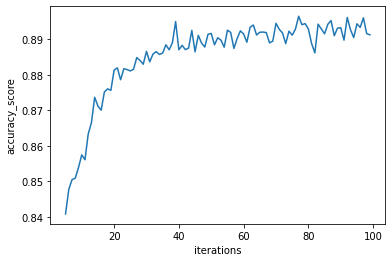

In [35]:
plt.xlabel("iterations")
plt.ylabel("accuracy_score")
plt.plot(x_label,y_label)
print('optimal estimator', x_label[np.argmax(y_label)])
print('best accuracy', np.max(y_label))

In [22]:
kf = KFold(n_splits = 5)
accure = []
for loss in tqdm(['mse', 'exp', 'log']):
    my_clf = MyGradientBoostingClassifier(loss = loss, n_estimators = 77, max_depth = 5)
    accuracy = 0
    if loss != 'mse':
        new_y = copy.deepcopy(y)
        new_y[new_y < 1] = -1
    else:
        new_y = y
    for train_index, test_index in kf.split(X):
        my_clf.fit(X[train_index], new_y[train_index])
        accuracy += accuracy_score(my_clf.predict(X[test_index]), new_y[test_index])
    accure.append(accuracy / 5)

100%|██████████| 3/3 [01:04<00:00, 21.41s/it]


In [23]:
print(accure)

[0.8309593023255815, 0.41778100775193805, 0.41603682170542633]


In [38]:
accure = []
for step in tqdm([0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.8, 1.0]):
    my_clf = MyGradientBoostingClassifier(learning_rate = step, n_estimators = 77, max_depth = 5)
    accuracy = 0
    for train_index, test_index in kf.split(X):
        my_clf.fit(X[train_index], y[train_index])
        accuracy += accuracy_score(my_clf.predict(X[test_index]), y[test_index])
    accure.append(accuracy / 5)

100%|██████████| 10/10 [03:37<00:00, 21.76s/it]


optimal learning_rate 0.1


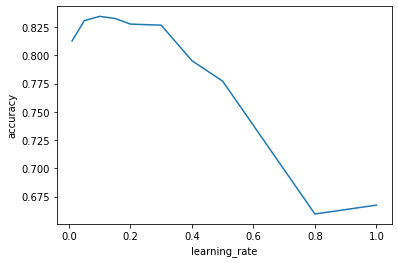

In [39]:
plt.xlabel('learning_rate')
plt.ylabel('accuracy')
plt.plot([0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.8, 1.0], accure)
print('optimal learning_rate', [0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.8, 1.0][np.argmax(accure)])

In [40]:
accure = []
pair = []
for col in tqdm([0.2, 0.4, 0.6, 0.8, 1.0]):
    for sub in [0.2, 0.4, 0.6, 0.8, 1.0]:
        my_clf = MyGradientBoostingClassifier(learning_rate = 0.1, n_estimators = 77,
                                                      colsample = col, subsample = sub, max_depth = 5)
        accuracy = 0
        for train_index, test_index in kf.split(X):
            my_clf.fit(X[train_index], y[train_index])
            accuracy += accuracy_score(my_clf.predict(X[test_index]), y[test_index])
        accure.append(accuracy / 5)
        pair.append((col, sub))

100%|██████████| 5/5 [03:17<00:00, 39.57s/it]


In [41]:
print('optimal sample percent',pair[np.argmax(accure)][1])
print('optimal column percent',pair[np.argmax(accure)][0])

optimal sample percent 1.0
optimal column percent 1.0


In [45]:
accure = []
pair = []
for col in tqdm([0.85, 0.9, 0.95, 1.0]):
    for sub in [0.85, 0.9, 0.95, 1.0]:
        my_clf = MyGradientBoostingClassifier(learning_rate = 0.1, n_estimators = 77,
                                                      colsample = col, subsample = sub, max_depth = 5)
        accuracy = 0
        for train_index, test_index in kf.split(X):
            my_clf.fit(X[train_index], y[train_index])
            accuracy += accuracy_score(my_clf.predict(X[test_index]), y[test_index])
        accure.append(accuracy / 5)
        pair.append((col, sub))

100%|██████████| 4/4 [04:53<00:00, 73.49s/it]


In [46]:
print('optimal sample percent',pair[np.argmax(accure)][1])
print('optimal column percent',pair[np.argmax(accure)][0])

optimal sample percent 1.0
optimal column percent 1.0


Оптимальные параметры:

1)loss = mse

2)learning_rate = 0.1

3)n_estimators = 77

4)colsample = 1.0

5)subsample = 1.0

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
my_clf = MyGradientBoostingClassifier(learning_rate = 0.1, n_estimators = 77,
                                                      colsample = 1.0, subsample = 1.0, max_depth = 5)
my_clf.fit(X_train, y_train)
accuracy_score(my_clf.predict(X_test), y_test)

0.8946220930232558

## BooBag BagBoo (1 балл)



Попробуем объединить бустинг и бэгинг. Давайте

1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn)

2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять

Попробуйте обе этих стратегии на данных из прошлого задания. Получилось ли улучшить качество? Почему?

In [24]:
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor

Попробуем в качестве базовой модели выбрать случайный лес.

In [66]:
my_clf = MyGradientBoostingClassifier(learning_rate=0.1, n_estimators=77, colsample=1.0,
                                             subsample=1.0, max_depth = 5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
my_clf.fit(X_train, y_train, base_model=RandomForestRegressor)
accuracy_score(my_clf.predict(X_test), y_test)

0.8980135658914729

А теперь попробуем обучить 100 бустингов

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
predict = np.ones(X_test.shape[0])
for i in tqdm(range(100)):
    samples = np.random.randint(0, X_train.shape[0], size = X_train.shape[0])
    my_clf = MyGradientBoostingClassifier(learning_rate = 0.1, n_estimators = 77,
                                                      colsample = 1.0, subsample = 1.0, max_depth = 5)
    my_clf.fit(X_train[samples], y_train[samples])
    predict += my_clf.predict(X_test)
print(accuracy_score(np.round(predict / 100), y_test))

100%|██████████| 100/100 [06:19<00:00,  3.80s/it]

0.9016472868217055


In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
my_clf = MyGradientBoostingClassifier(learning_rate = 0.1, n_estimators = 77,
                                                      colsample = 1.0, subsample = 1.0, max_depth = 5)
bagg = BaggingRegressor(base_estimator = my_clf, random_state = 0, n_estimators = 100)
bagg.fit(X_train, y_train)
accuracy_score(np.round(bagg.predict(X_test)), y_test)

0.876937984496124

Как мы видим, качество не сильно увеличилось.На пару десятых процента. В базовом алгоритме мы уже используем в качестве базовой модели Дерево Решений, поэтому BagBoo не особо нам поможет, так как каждый бустинг он +- похож на другие, соответственно предикт будет одинаковый. BooBag тоже не очень помог, видимо я изначально подобрал параметры так, что мое предсказание достаточно точное) И случайный лес не дал преимущества, так как он обучает деревя на части выборки, в то время как наше дерево решений на всей выборке.

## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



In [70]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

In [76]:
my_clf = MyGradientBoostingClassifier(learning_rate = 0.1, n_estimators = 77,
                                                      colsample = 1.0, subsample = 1.0, max_depth = 5)
my_clf.fit(X_train, y_train, init_model = LinearRegression)
accuracy_score(my_clf.predict(X_test), y_test)

0.8965600775193798

In [77]:
my_clf = MyGradientBoostingClassifier(learning_rate = 0.1, n_estimators = 77,
                                                      colsample = 1.0, subsample = 1.0, max_depth = 5)
my_clf.fit(X_train, y_train, init_model = RandomForestRegressor)
accuracy_score(my_clf.predict(X_test), y_test)

0.8878391472868217

In [75]:
my_clf = MyGradientBoostingClassifier(learning_rate = 0.1, n_estimators = 77,
                                                      colsample = 1.0, subsample = 1.0, max_depth = 5)
my_clf.fit(X_train, y_train, init_model = SVR)
accuracy_score(my_clf.predict(X_test), y_test)

0.8989825581395349

В данном случае качество тоже не особо выросло, потому что у нас задача бинарной классификации, соответственно нужно предсказать, класс 1 или 0 у объекта. В качестве начального приближения я брал вектор из среднего значения классов, и это довольно хорошее начальный предикт, так как и на тестовой, и на трейновой выборке начальное приближение у меня соотношение разных классов примерно одинаковое. Все испробованные мной модели в качестве начальной давали предикт на тестовых объектах, и их предсказание не сильно лучше моего начального приближения, так как эти предсказания содержат в себе ошибки, которые потом исправляют деревья решений.

## Фидбек (бесценно)

* Какие аспекты обучения  ансамблей Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

